# What's this?
International Students in the US under the F-1 visa usually submit form I-765 to apply for work authorization from USCIS (under the OPT program). Conventional wisdom says that processing times for the work authorization can be up to 90 days. Recently (late 2017 - early 2018), the times *seem* to be increasing.

I read a short [book](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) on Bayesian statistics recently, and thought this would be a good chance to put what I learnt into practice.

*tldr: I want to test if I-765 processing times have increased recently*

## Why Bayesian?
If I took a frequentist approach, I could have just taken the mean of the scraped processing times and used that as my best guess of how long OPT processing times are recently. However, this approach ignores the uncertainty inherent in real-world sampling.

# Methodology
1. Scrape USCIS website for receipts YSC1890050000 to YSC1890070000 into `results.csv`, using Scraproxy and Scrapy.
2. Filter out irrelevant rows, leaving only *processed* or *processing* I-765 cases, into `filtered.csv`, using `csv_filter.py`.
3. Only in the "Case Was Received" cases do we have a submission date for the OPT application. In other cases, we use the nearest two cases with submission dates to interpolate to an estimated submission date. This works because receipt numbers are chronologically increasing.
4. Process using pymc3 (**see below**)

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt

/Users/yiyantay/default_venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


101.08544250042466

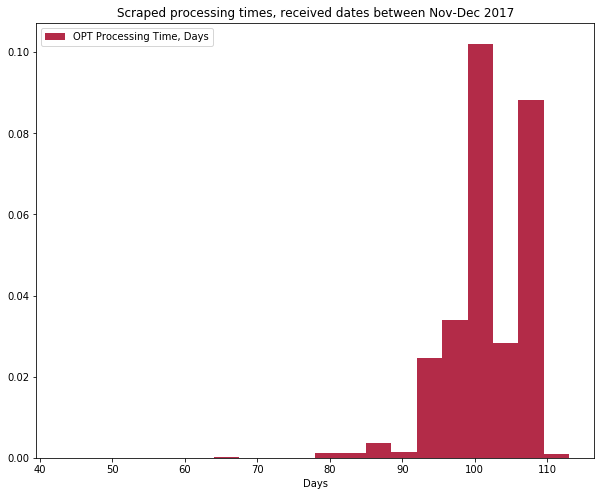

In [123]:
figsize(10, 8)
data=np.loadtxt('interpolated.csv',delimiter = ' ',dtype={'names': ('status', 'days'),'formats': ('S1', 'i4')})
filtered_data = np.array([d[1] for d in data if d[0]==b'd'])
np.random.shuffle(filtered_data)
plt.hist(filtered_data, histtype='stepfilled', bins=20, alpha=0.85,
         label="OPT Processing Time, Days", color="#A60628", density=True)
plt.title("Scraped processing times, received dates between Nov-Dec 2017")
plt.legend(loc="upper left")
plt.xlabel("Days")
filtered_data.mean()

Let \\(Processing \, Days\\) be the random variable indicating the number of days an I-765 case needs to be processed. I assume that \\(Processing \, Days \sim Normal(\mu_p, \sigma_p^{2})\\). To use Bayesian inference, I need to assign prior probabilities to the different possible values of \\(\mu_p\\) and \\(\sigma_p\\) .

According to an online tracking [site](http://www.trackitt.com/), the mean (self-reported) processing time is 74 days. We can model this as \\(\mu_p \sim Normal(74, 20^{2})\\) (where 20 is a randomly-plucked number for our standard deviation). I'm not very sure of what \\(\sigma_p\\) could be, so I let \\(\sigma_p \sim Uniform(0,45)\\) - with the broad-ranged uniform distribution reflecting my lack of strong prior belief.

In [117]:
with pm.Model() as model:
    lambda_ = pm.Normal("lambda", mu=74, sd = 20)
    sd = pm.Uniform("sd", lower=0,upper=45)
    processing_time = pm.Normal("processing_time", mu=lambda_, sd=sd, observed=filtered_data)

In [118]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, start=pm.find_MAP())

logp = -18,127, ||grad|| = 0.75414: 100%|██████████| 24/24 [00:00<00:00, 1417.59it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd_interval__]
>Metropolis: [lambda]
100%|██████████| 15000/15000 [00:04<00:00, 3107.06it/s]
The number of effective samples is smaller than 25% for some parameters.


101.08529172991734

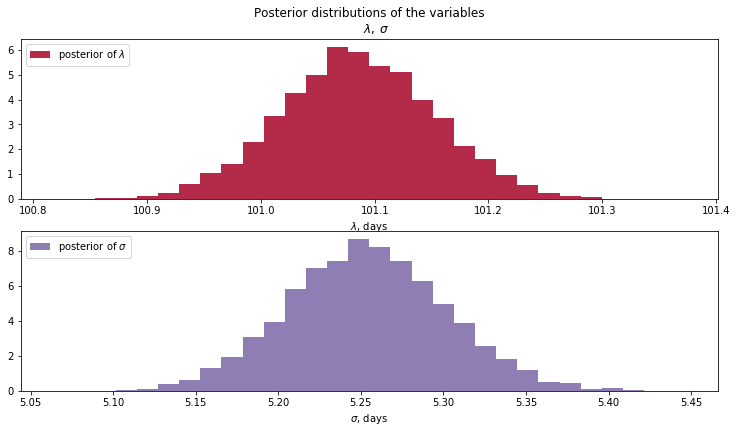

In [124]:
lambda_samples = trace['lambda']
sigma_samples = trace['sd']

figsize(12.5, 10)
#histogram of the samples:
 
ax = plt.subplot(311)

plt.hist(lambda_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda,\;\sigma$""")
plt.xlabel("$\lambda$, days")

ax = plt.subplot(312)
plt.hist(sigma_samples, histtype='stepfilled', bins=30, alpha=0.85,
       label="posterior of $\sigma$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\sigma$, days");
trace['lambda'].mean()

Because we have >10000 observations, the Bayesian result for \\(\lambda_p\\) is actually very close to the sample mean. This doesn't mean that the Bayesian analysis was for nought though - we also get measures of uncertainty in the form of a distribution for \\(\lambda_p\\) and \\(\sigma_p\\).

# Credits
This was inspired by Linan's OPT processing time [post](http://linanqiu.github.io/2016/05/24/OPT-I-765-Processing-Time/). The additions in my project are:

1. Using Bayesian inference to infer the posterior distributions for I-765 processing times.
2. Doing linear interpolation to get the OPT application date, for cases where it is not displayed.
3. Using python for scraping rather than javascript.